# 08 - Feature Selection and Engineering Round 2
____

From our initital modelling we found that our F1 score on the training set was quite high (80%) but dropped quite severely (to 50%) when we performed cross-fold (5 fold) validation on the same data. This is indicative that we were quite severely overfitting to the training data.

To investigate this further, we performed recursive feature elimination. This technique selectively removes features to identify the key features. From a graph of the F1 Score versus the number of features that the RFE model used, we found an inflection point at 21 features: after this point, additional features didn't add extra information to the model, so we have a lot of superfluous information.

Our top features also included 'day_sin', 'day_cos', 'month_cos', 'hour_sin', and 'hour_cos' quite high on the importance list. We are mostly likely overfitting to the timestamp of the collisions. We can certainly furhter engineer the time data.

Our casualty class and casualty type also contains similar information - can we combine these features?

There are very few collisions with a high number of casualties / vehicles so we could roll these into a 3+ category. The no of cas and no of vehs is also somewhat correlated (as you might expect) so could we combine these features?

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
train = pd.read_csv('feat_sel_training_data.csv')
test = pd.read_csv('feat_sel_testing_data.csv')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   accident_year                            11337 non-null  int64 
 1   number_of_vehicles                       11337 non-null  int64 
 2   number_of_casualties                     11337 non-null  int64 
 3   first_road_class                         11337 non-null  object
 4   road_type                                11337 non-null  object
 5   speed_limit                              11337 non-null  int64 
 6   junction_detail                          11337 non-null  object
 7   second_road_class                        11337 non-null  object
 8   pedestrian_crossing_physical_facilities  11337 non-null  object
 9   light_conditions                         11337 non-null  object
 10  urban_or_rural_area                      11337 non-null  o

In [29]:
for dataset in [train, test]:
  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type == 'Car occupant'), 'casualty_type'] = 'Car driver'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type == 'Car occupant'), 'casualty_type'] = 'Car passenger'
  dataset.loc[dataset.car_passenger.str.contains('unknown|missing', case=False), 'car_passenger'] = 'Front seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger') & (dataset.car_passenger == 'Front seat passenger'), 'casualty_type'] = 'Car front seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger') & (dataset.car_passenger == 'Rear seat passenger'), 'casualty_type'] = 'Car rear seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger'), 'casualty_type'] = 'Car front seat passenger'

  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle rider'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle passenger'

  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type == 'Large Vehicle'), 'casualty_type'] = 'Large vehicle driver'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type == 'Large Vehicle'), 'casualty_type'] = 'Large vehicle passenger'


  dataset.loc[dataset.casualty_type.str.contains('mobility|agricultural|horse|mobility scooter rider', case = False), 'casualty_type'] = 'Other'

  dataset.drop(labels='casualty_class', inplace=True, axis=1)

The car_passenger column contains the same information as our new casualty_type column, so we can drop this.

In [30]:
for dataset in [train, test]:
  dataset.drop(columns='car_passenger', axis=1, inplace=True)

Let's create a rush hour feature, a weekend feature and a daytime vs nighttime feature from our time and day columns.

First up, rush hour.

In [31]:
rush_hours = [7, 8, 9, 10, 16, 17, 18, 19] #only mon - fri
night_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
weekend = [5, 6] # Indexed from Monday:0 to Sunday:6. Also friday after rush hour


for dataset in [train, test]:
  # First we need to reengineer our day of the week
  dataset.rename(columns={'accident_year': 'Year'}, inplace=True)
  dataset['date'] = pd.to_datetime(dataset[['Year', 'Month', 'Day']])
  dataset['day_of_week'] = dataset.date.dt.day_of_week
  #If its not the weekend and it's rush hour, then rush hour
  dataset.loc[(~dataset.day_of_week.isin(weekend)) & (dataset.Hour.isin(rush_hours)), 'rushhour'] = True
  dataset.loc[(dataset.day_of_week.isin(weekend), 'rushhour')] = False
  dataset.loc[(~dataset.day_of_week.isin(weekend) & (~dataset.Hour.isin(rush_hours)), 'rushhour')] = False



C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\3770846768.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[(~dataset.day_of_week.isin(weekend)) & (dataset.Hour.isin(rush_hours)), 'rushhour'] = True
C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\3770846768.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[(~dataset.day_of_week.isin(weekend)) & (dataset.Hour.isin(rush_hours)), 'rushhour'] = True


Now, daytime or night time?

In [32]:
for dataset in [train, test]: 
  dataset.loc[dataset.Hour.isin(night_hours), 'nighttime'] = True
  dataset.loc[~dataset.Hour.isin(night_hours), 'nighttime'] = False


C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\2903942194.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset.Hour.isin(night_hours), 'nighttime'] = True
C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\2903942194.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset.Hour.isin(night_hours), 'nighttime'] = True


Weekend or not? Let's include Friday nights as weekends (i.e. after rush hour on Friday)

In [33]:
for dataset in [train, test]: 
  # If saturday or sunday then weekend
  dataset.loc[dataset.day_of_week.isin(weekend), 'weekend'] = True
  # If friday and the hour is > than the end of rush hour, then weekend
  dataset.loc[(dataset.day_of_week == 4) & (dataset.Hour > max(rush_hours)), 'weekend'] = True
  dataset.loc[dataset.weekend != 1, 'weekend'] = False



C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\3704356794.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset.day_of_week.isin(weekend), 'weekend'] = True
C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\3704356794.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.loc[dataset.day_of_week.isin(weekend), 'weekend'] = True


Let's drop those time/date columns that we're over fitting to.

In [34]:
cols_to_drop = ['Hour', 'Month', 'Day', 'Year', 'date', 'day_of_week']
for dataset in [train, test]:
  dataset.drop(columns=cols_to_drop, inplace=True, axis=1)

In [35]:
for dataset in [train, test]:
  dataset['number_of_vehicles'] = np.where(dataset['number_of_vehicles'] >= 3, '3+', dataset['number_of_vehicles'])
  dataset['number_of_casualties'] = np.where(dataset['number_of_casualties'] >= 3, '3+', dataset['number_of_casualties'])


<Axes: >

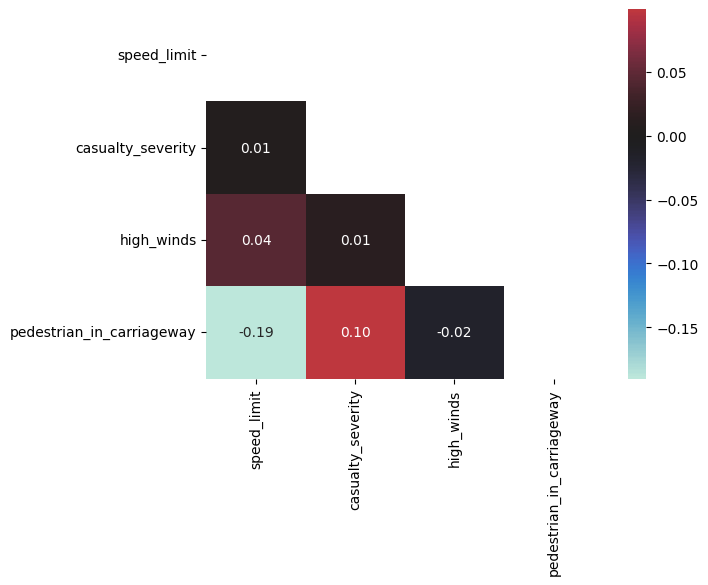

In [37]:
corr = train.select_dtypes(include=[np.number, bool]).corr()
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0, annot=True, fmt=".2f")

In [38]:
train.to_csv('feat_sel_2_training_data.csv', index=False)
test.to_csv('feat_sel_2_testing_data.csv', index=False)